In [2]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [3]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_760679.tsv', sep='\t')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,HCT116,A549
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.018,-0.048,0.017,-0.708,NaN
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.043,0.191,0.099,-0.262,NaN
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.005,0.650,-0.185,0.627,NaN
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.762,0.281,0.676,NaN
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.455,-0.643,0.066,-0.164,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.716,1.309,1.089,NaN,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.544,-0.427,NaN,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.143,-0.195,-0.308,NaN,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.116,-0.084,-0.385,NaN,NaN


In [4]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [5]:
data_split_dict = {}

data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test']  = MPRA_df['chr'].isin(['chr2'])

# 和前三种细胞类型差异top5%的序列定义为cell type specific
for cell_type in cell_types:
    ref_mean = MPRA_df[cell_types[:3]].mean(axis=1)
    diff = (MPRA_df[cell_type] - ref_mean).abs()
    threshold = np.percentile(diff.dropna(), 95)
    data_split_dict[f'{cell_type}_specific'] = diff > threshold


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
train 631073
valid 70952
test 58654
K562_specific 38034
HepG2_specific 38034
SK-N-SH_specific 38034
HCT116_specific 22406
A549_specific 15975


In [6]:
y_pred = np.load(f'../saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/Gosai_pred.npy')

pred_cols = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[pred_cols] = y_pred
MPRA_df.describe()

,pos,K562,HepG2,SK-N-SH,HCT116,A549,K562_pred,HepG2_pred,SK-N-SH_pred,HCT116_pred,A549_pred
count,760679.000,760679.000,760679.000,760679.000,448103.000,319496.000,760679.000,760679.000,760679.000,760679.000,760679.000
mean,75202958.598,-0.000,-0.000,0.000,0.000,-0.000,0.045,0.032,0.035,0.048,0.048
std,57521411.054,1.000,1.000,1.000,1.000,1.000,1.010,0.982,0.991,1.019,1.006
min,14677.000,-5.360,-5.745,-5.762,-5.956,-6.017,-2.741,-3.029,-3.091,-2.811,-2.902
25%,28973267.000,-0.564,-0.597,-0.569,-0.567,-0.504,-0.525,-0.536,-0.526,-0.525,-0.526
50%,62363640.000,-0.283,-0.256,-0.206,-0.272,-0.203,-0.272,-0.260,-0.221,-0.268,-0.257
75%,112600466.000,0.206,0.284,0.285,0.208,0.215,0.187,0.217,0.241,0.204,0.212
max,249200985.000,7.854,7.705,8.315,7.761,11.771,7.877,7.853,7.923,7.827,7.903


In [16]:
VEF_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_VEF_zscore.tsv', sep='\t')


for data_split in ['total', 'test']:
    pearson_df = pd.DataFrame()
    for c1 in cell_types:
        for c2 in cell_types:
            if c1 == c2:
                pearson_df.loc[f'{c1}', f'{c2}'] = np.nan
                continue
            if data_split == 'specific':
                cond = data_split_dict[f'{c1}_specific']
            elif data_split == 'test+specific':
                cond = data_split_dict[f'{c1}_specific'] & data_split_dict['test']
            else:
                cond = data_split_dict[data_split]
            x = MPRA_df.loc[cond, f'{c1}'] - MPRA_df.loc[cond, f'{c2}']
            y = VEF_df.loc[cond, f'{c1}_DNase'] - VEF_df.loc[cond, f'{c2}_DNase']
            r, p = pearson(x, y)
            pearson_df.loc[f'{c1}', f'{c2}'] = r
    print(data_split, len(x))
    print(pearson_df)

total 760679
         K562  HepG2  SK-N-SH  HCT116  A549
K562      NaN  0.305    0.180   0.291 0.264
HepG2   0.305    NaN    0.208   0.185 0.204
SK-N-SH 0.180  0.208      NaN   0.112 0.163
HCT116  0.291  0.185    0.112     NaN 0.072
A549    0.264  0.204    0.163   0.072   NaN
test 58654
         K562  HepG2  SK-N-SH  HCT116  A549
K562      NaN  0.302    0.170   0.269 0.256
HepG2   0.302    NaN    0.216   0.204 0.175
SK-N-SH 0.170  0.216      NaN   0.095 0.166
HCT116  0.269  0.204    0.095     NaN 0.098
A549    0.256  0.175    0.166   0.098   NaN


In [11]:
for data_split in ['total', 'test']:
    pearson_df = pd.DataFrame()
    for c1 in cell_types:
        for c2 in cell_types:
            if data_split == 'specific':
                cond = data_split_dict[f'{c1}_specific']
            elif data_split == 'test+specific':
                cond = data_split_dict[f'{c1}_specific'] & data_split_dict['test']
            else:
                cond = data_split_dict[data_split]
            df = MPRA_df[cond]
            x = df[f'{c1}'] - df[f'{c2}']
            y = df[f'{c1}_pred'] - df[f'{c2}_pred']
            r, p = pearson(x, y)
            pearson_df.loc[f'{c1}', f'{c2}'] = r
    print(data_split, len(x))
    print(pearson_df)

/home/hxcai/cell_type_specific_CRE/MPRA_predict/predict_CRE_activity/../MPRA_predict/utils/data_utils.py:118: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)
/home/hxcai/cell_type_specific_CRE/MPRA_predict/predict_CRE_activity/../MPRA_predict/utils/data_utils.py:118: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)
/home/hxcai/cell_type_specific_CRE/MPRA_predict/predict_CRE_activity/../MPRA_predict/utils/data_utils.py:118: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)
/home/hxcai/cell_type_specific_CRE/MPRA_predict/predict_CRE_activity/../MPRA_predict/utils/data_utils.py:118: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)
/home/hxcai/cell_type_specific_CRE/MPRA_predict/predict_CRE_activity/../MPRA_predict/uti

total 760679
         K562  HepG2  SK-N-SH  HCT116  A549
K562      NaN  0.652    0.720   0.376 0.437
HepG2   0.652    NaN    0.625   0.294 0.361
SK-N-SH 0.720  0.625      NaN   0.412 0.311
HCT116  0.376  0.294    0.412     NaN 0.078
A549    0.437  0.361    0.311   0.078   NaN
test 58654
         K562  HepG2  SK-N-SH  HCT116  A549
K562      NaN  0.489    0.557   0.269 0.359
HepG2   0.489    NaN    0.472   0.215 0.274
SK-N-SH 0.557  0.472      NaN   0.330 0.268
HCT116  0.269  0.215    0.330     NaN 0.005
A549    0.359  0.274    0.268   0.005   NaN


/home/hxcai/cell_type_specific_CRE/MPRA_predict/predict_CRE_activity/../MPRA_predict/utils/data_utils.py:118: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)


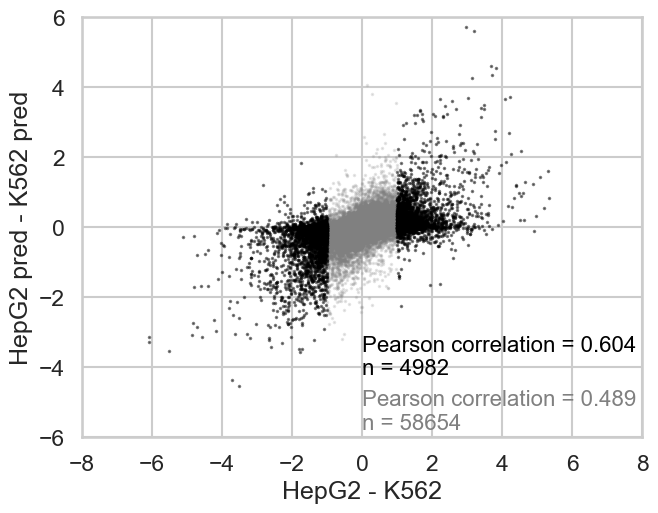

In [12]:
cond_0 = data_split_dict['test']
df = MPRA_df.loc[cond_0]

c1 = 'HepG2'
c2 = 'K562'


sns.set_theme('talk', 'whitegrid')
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

x = df[f'{c1}'] - df[f'{c2}']
y = df[f'{c1}_pred'] - df[f'{c2}_pred']

x_1 = x[x.abs() < 1]
y_1 = y[x.abs() < 1]
x_2 = x[x.abs() >= 1]
y_2 = y[x.abs() >= 1]

scatter = plt.scatter(x_1, y_1, s=1, c='gray', alpha=0.2)
scatter = plt.scatter(x_2, y_2, s=1, c='black', alpha=0.5)

r = pearson(x, y)[0]
r_2 = pearson(x_2, y_2)[0]
plt.text(
    x=0.5, y=0.02, transform=plt.gca().transAxes, fontsize=16,
    s=f'Pearson correlation = {r:.3f} \nn = {len(x)}', color='gray',
)

plt.text(
    x=0.5, y=0.15, transform=plt.gca().transAxes, fontsize=16,
    s=f'Pearson correlation = {r_2:.3f} \nn = {len(x_2)}', color='black',
)


plt.xlabel(f'{c1} - {c2}')
plt.ylabel(f'{c1} pred - {c2} pred')
plt.xlim([-8, 8])
plt.ylim([-6, 6])
plt.savefig(f'figures/Gosai_MPRA_{c1}-{c2}_scatter.png', dpi=400)
plt.savefig(f'figures_pdf/Gosai_MPRA_{c1}-{c2}_scatter.pdf', dpi=400)
plt.show()

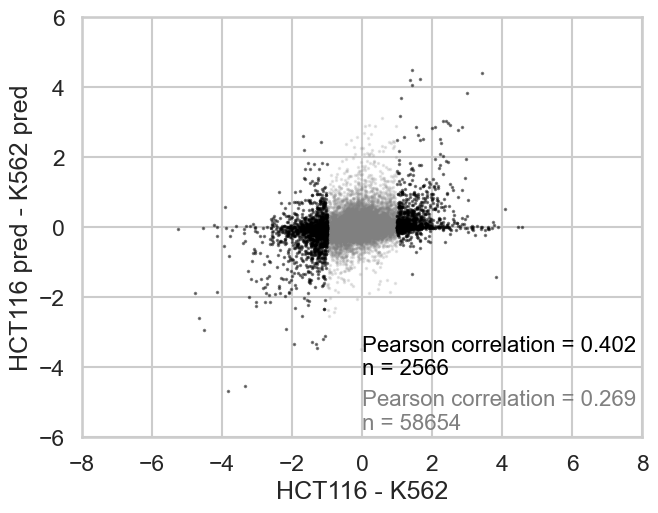

In [13]:
cond_0 = data_split_dict['test']
df = MPRA_df.loc[cond_0]

c1 = 'HCT116'
c2 = 'K562'


sns.set_theme('talk', 'whitegrid')
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

x = df[f'{c1}'] - df[f'{c2}']
y = df[f'{c1}_pred'] - df[f'{c2}_pred']

x_1 = x[x.abs() < 1]
y_1 = y[x.abs() < 1]
x_2 = x[x.abs() >= 1]
y_2 = y[x.abs() >= 1]

scatter = plt.scatter(x_1, y_1, s=1, c='gray', alpha=0.2)
scatter = plt.scatter(x_2, y_2, s=1, c='black', alpha=0.5)

r = pearson(x, y)[0]
r_2 = pearson(x_2, y_2)[0]
plt.text(
    x=0.5, y=0.02, transform=plt.gca().transAxes, fontsize=16,
    s=f'Pearson correlation = {r:.3f} \nn = {len(x)}', color='gray',
)

plt.text(
    x=0.5, y=0.15, transform=plt.gca().transAxes, fontsize=16,
    s=f'Pearson correlation = {r_2:.3f} \nn = {len(x_2)}', color='black',
)


plt.xlabel(f'{c1} - {c2}')
plt.ylabel(f'{c1} pred - {c2} pred')
plt.xlim([-8, 8])
plt.ylim([-6, 6])
plt.savefig(f'figures/Gosai_MPRA_{c1}-{c2}_scatter.png', dpi=400)
plt.savefig(f'figures_pdf/Gosai_MPRA_{c1}-{c2}_scatter.pdf', dpi=400)
plt.show()